# Modello bayesiano di regressione lineare bivariata {#sec-bivariate-bayesian-regression}

**Prerequisiti**

- Leggere *Regression and Other Stories* [@gelman2020regression].
  - Prestare particolare attenzione ai capitoli 1 "Overeview, 6, "Background on Regression Modeling," 7, "Linear Regression with a Single Predictor" e 8, "Fitting regression models", che offrono una guida dettagliata al modello di regressione bivariato.

**Concetti e Competenze Chiave**

- Comprendere il significato del modello di regressione lineare bayesiano e le differenze rispetto al modello frequentista.
- Interpretare le stime dei parametri in un contesto bayesiano e confrontarle con l'interpretazione dei parametri nell'approccio frequentista.
- Capire il metodo dei minimi quadrati.
- Capire il concetto di verosimiglianza per il modello di regressione.
- Capire il codice Stan per il modello di regressione.
- Comprendere il significato delle previsioni del modello di regressione nell'ambito bayesiano.
- Capire e sapere interpretare il Posterior Predictive Check nel modello bayesiano.
- Capire il concetto di regressione verso la media.

**Preparazione del Notebook**

In [1]:
# Importazioni dalla libreria standard
import os
import logging

# Importazioni di librerie di terze parti
import pandas as pd
import numpy as np
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import statsmodels.api as sm
import cmdstanpy
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)
from cmdstanpy import CmdStanModel
import pingouin as pg
from sklearn.linear_model import LinearRegression
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [3]:
# Configurazione
seed = sum(map(ord, "bayesian_bivariate_regression"))  # Genera un seme basato sulla somma dei valori ASCII della stringa "linear_algebra"
rng = np.random.default_rng(seed=seed)  # Crea un generatore di numeri casuali con il seme specificato
sns.set_theme(palette="colorblind")  # Imposta il tema di Seaborn per grafici accessibili ai daltonici
az.style.use("arviz-darkgrid")  # Imposta lo stile dei grafici di ArviZ
%config InlineBackend.figure_format = "retina"  # Migliora la risoluzione dei grafici inline

# Definizione delle directory
home_directory = os.path.expanduser("~")  # Ottiene la directory home dell'utente
project_directory = f"{home_directory}/_repositories/psicometria"  # Definisce la directory del progetto

# Stampa la directory del progetto per verificarla
print(f"Directory del progetto: {project_directory}")

def standardize(series):
    """Standardize a pandas series with n degrees of freedom"""
    return (series - series.mean()) / series.std(ddof=0)

## Introduzione {.unnumbered}

I modelli lineari sono stati impiegati in molteplici contesti per lungo tempo. Come descritto da @stigler1986, il metodo dei minimi quadrati, una tecnica per adattare una semplice regressione lineare, veniva già utilizzato nel XVIII secolo per affrontare problemi di analisi dei dati in astronomia. Ad esempio, questo metodo era impiegato per determinare il moto della Luna e per riconciliare i movimenti non periodici di Giove e Saturno. All'epoca, gli astronomi erano tra i primi a sentirsi a proprio agio nell'uso di tali metodi, poiché raccoglievano personalmente le loro osservazioni e sapevano che le condizioni di raccolta dei dati erano omogenee, anche se i valori osservati potevano differire. Questo contrastava con l'approccio più cauto delle scienze sociali, dove la riluttanza a combinare dati eterogenei ritardava l'adozione dei modelli lineari [@stigler1986].

In questa sezione della dispensa, esploreremo due modelli statistici fondamentali: la regressione lineare bivariata e la regressione lineare multipla. Il primo modello considera una sola variabile esplicativa, mentre il secondo ne include diverse.

È cruciale sottolineare che i modelli statistici sono principalmente utilizzati per due scopi: inferenza e previsione. La previsione si limita a descrivere l'associazione tra le variabili, mentre l'inferenza mira a stabilire relazioni di causa-effetto attraverso l'uso del modello lineare. Mentre la previsione non è una tecnica controversa e può essere facilmente verificata sulla base della sua effettiva capacità di predire la variabile dipendente, l'uso della regressione per l'inferenza causale è molto più problematico. Esso richiede una profonda comprensione del fenomeno in esame e una progettazione sperimentale o quasi-sperimentale adeguata per giustificare le assunzioni necessarie.

Indipendentemente dall'approccio scelto, è fondamentale tenere presente che l'analisi di regressione è essenzialmente una forma di media ponderata. Di conseguenza, i risultati ottenuti riflettono inevitabilmente i bias e le peculiarità del dataset utilizzato.

Per ciascun modello, esamineremo due approcci distinti:

1. L'utilizzo delle funzioni di `pingouin`, particolarmente utile per l'analisi esplorativa dei dati (EDA) quando si necessita di risultati rapidi.
2. L'approccio bayesiano, ideale quando l'obiettivo principale è l'inferenza statistica.

## Adattare una Retta di Regressione a Dati Simulati

Simuliamo 20 osservazioni di $x$ e $y$, dove $y$ è generato in base a un modello di regressione teorico con i parametri specificati di seguito.

In [4]:
# Set seed for reproducibility
np.random.seed(123)

# Define variables
x = np.arange(1, 21)
n = len(x)
a = 0.2
b = 0.3
sigma = 0.5

# Generate y values
y = a + b * x + sigma * np.random.normal(size=n)

fake = pd.DataFrame({"x": x, "y": y})
fake.head()

,x,y
0,1,-0.042815
1,2,1.298673
2,3,1.241489
3,4,0.646853
4,5,1.410700


Adattiamo ai dati un modello di regressione bayesiano. Compiliamo e stampiamo il codice Stan.

In [5]:
stan_file = os.path.join(project_directory, "stan", "bivariate_linreg_model.stan")
model = CmdStanModel(stan_file=stan_file)
print(model.code())

data {
  int<lower=1> N;
  vector[N] x;
  vector[N] y;
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
model {
  y ~ normal(alpha + beta * x, sigma);
  alpha ~ normal(0, 2.5);
  beta ~ normal(0, 2.5);
  sigma ~ normal(0, 2.5);
}
generated quantities {
  array[N] real y_rep = normal_rng(alpha + beta * x, sigma);
}



Definiamo un dizionario che contiene i dati nel formato attesto da Stan.

In [6]:
stan_data = {"N": len(fake["x"]), "x": fake["x"], "y": fake["y"]}

Eseguiamo il campionamento.

In [7]:
fit = model.sample(
    data=stan_data,
    iter_warmup=2_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False
)

Esaminiamo una sintesi della distribuzione a posteriori dei parametri.

In [8]:
az.summary(fit, var_names=(["alpha", "beta", "sigma"]), hdi_prob=0.94).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.15,0.30,-0.73,0.40,0.01,0.0,2639.0,3041.0,1.0
beta,0.34,0.02,0.29,0.39,0.00,0.0,2692.0,3281.0,1.0
sigma,0.64,0.12,0.45,0.86,0.00,0.0,3531.0,4126.0,1.0



Le prime due righe dell'output ci indicano che l'intercetta stimata è -0.15 con un'incertezza di 0.30, e la pendenza stimata è 0.34 con un'incertezza di 0.02. La deviazione standard residua $\sigma$ è stimata a 0.64 con un'incertezza di 0.12.

È utile disegnare un diagramma a dispersione con la retta di regressione stimata.

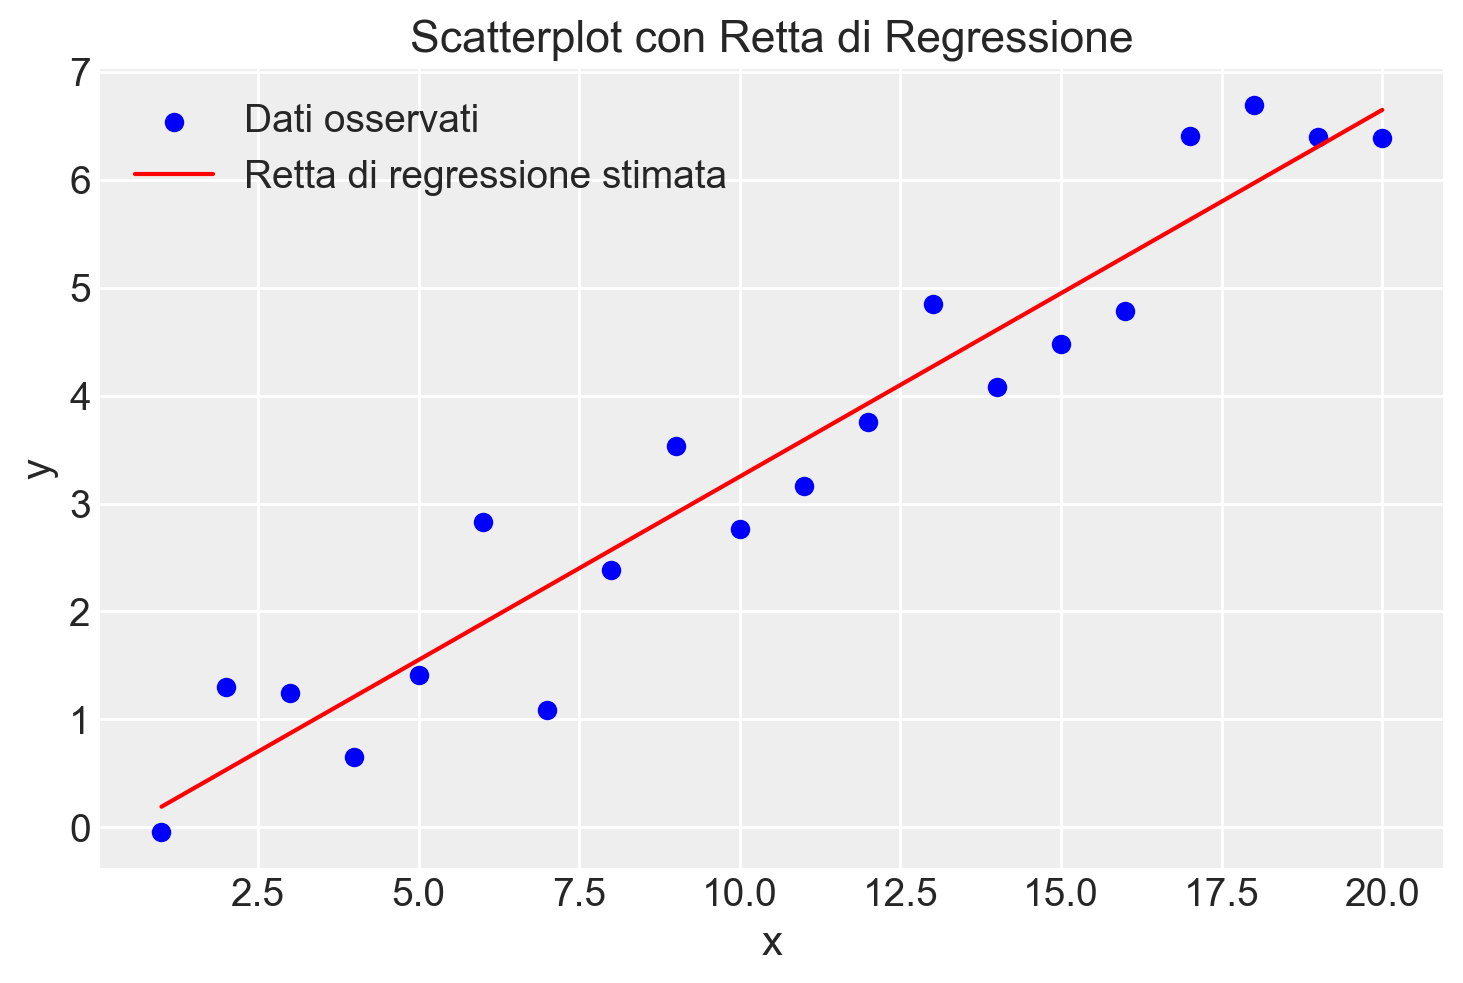

In [9]:
# Estrarre i parametri stimati dal modello bayesiano
alpha_hat = -0.15  # Stima media di alpha
beta_hat = 0.34  # Stima media di beta

# Scatterplot dei dati
plt.scatter(fake["x"], fake["y"], color="blue", label="Dati osservati")

# Disegnare la retta di regressione usando i parametri stimati
x_values = np.linspace(fake["x"].min(), fake["x"].max(), 100)
y_values = alpha_hat + beta_hat * x_values
plt.plot(x_values, y_values, color="red", label="Retta di regressione stimata")

# Aggiungere titoli e etichette
plt.title("Scatterplot con Retta di Regressione")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

# Mostrare il grafico
plt.show()

Vediamo che la retta stimata si adatta bene alla nube di punti del campione. Possiamo ora confrontare le stime con i valori dei parametri assunti. Cominciamo con l'intercetta $a$, che abbiamo impostato a 0.2 nelle simulazioni. Dopo aver adattato il modello ai dati simulati, la stima risulta essere 
−0.15, che è molto diversa dal valore assunto di 0.2 -- ma l'incertezza, o errore standard, nella stima è di 0.30. Approssimativamente, ci aspettiamo che la differenza tra la stima e il valore reale rientri in 1 errore standard nel 68% dei casi, e in 2 errori standard nel 95% dei casi. Quindi, se il valore reale è 0.2, e l'errore standard è 0.30, non è sorprendente che la stima risulti essere −0.15. Allo stesso modo, per le stime di $b$ e σ, l'intervallo di credibilità al 95% contiene i loro valori reali.

Come appena illustrato, una qualsiasi simulazione di dati fittizi con dati continui non riprodurrà esattamente i valori dei parametri assunti. Tuttavia, sotto simulazioni ripetute, dovremmo osservare una copertura adeguata.

Per semplicità, adottiamo l'approccio frequentista e consideriamo l'intervallo di confidenza al 95%. Per livello di copertura si intende la proporzione di volte in cui, nelle simulazioni, il valore reale del parametro rientra nell'intervallo di confidenza stimato a partire dai dati.

In [37]:
# Imposta il seme per la riproducibilità
np.random.seed(42)

# Parametri veri
a_true = 0.2
b_true = 0.3
sigma_true = 0.5

# Numero di simulazioni
num_simulations = 1000

# Per tracciare il livello di copertura
coverage_a = 0
coverage_b = 0

# Intervalli di confidenza al 95%
z_value = 1.96  # valore z per il 95% di confidenza

for _ in range(num_simulations):
    # Simula i dati
    x = np.arange(1, 21)
    n = len(x)
    y = a_true + b_true * x + sigma_true * np.random.normal(size=n)

    # Crea un DataFrame con i dati simulati
    fake = pd.DataFrame({"x": x, "y": y})

    # Fitting del modello
    X = sm.add_constant(fake["x"])  # Aggiunge il termine di intercetta
    model = sm.OLS(fake["y"], X).fit()

    # Estrazione dei parametri stimati
    a_hat = model.params[0]
    b_hat = model.params[1]

    # Calcolo degli errori standard
    se_a = model.bse[0]
    se_b = model.bse[1]

    # Calcolo degli intervalli di confidenza al 95%
    ci_a_low = a_hat - z_value * se_a
    ci_a_high = a_hat + z_value * se_a
    ci_b_low = b_hat - z_value * se_b
    ci_b_high = b_hat + z_value * se_b

    # Controlla se il valore vero è all'interno degli intervalli di confidenza
    if ci_a_low <= a_true <= ci_a_high:
        coverage_a += 1
    if ci_b_low <= b_true <= ci_b_high:
        coverage_b += 1

# Calcola e stampa i livelli di copertura
coverage_a_rate = coverage_a / num_simulations * 100
coverage_b_rate = coverage_b / num_simulations * 100

print(f"Livello di copertura per l'intercetta a: {coverage_a_rate:.2f}%")
print(f"Livello di copertura per la pendenza b: {coverage_b_rate:.2f}%")

Livello di copertura per l'intercetta a: 93.80%
Livello di copertura per la pendenza b: 94.10%


I valori di copertura ottenuti empiricamente mediante la simulazione sono prossimi ai valori teorici attesi.

## Modellare l'associazione statistica tra variabili

Avendo verificato che il modello di regressione è in grado di recuperare in modo attendibile i valori teorici dell'intercetta e della pendenza della retta di regressione, passiamo ora ad applicare il modello a un insieme di dati reali.

Esamineremo un set di [dati](../../data/affect.csv) che riguarda la relazione tra i punteggi di affect e arousal. Questi dati provengono da due studi condotti presso il Personality, Motivation, and Cognition Laboratory della Northwestern University, nei quali sono stati utilizzati film per indurre stati affettivi [@rafaeli2006premature].

Ci concentreremo sull'associazione tra l'ansia di stato, considerata come variabile indipendente, e la scala di *Tense Arousal* del *Motivational State Questionnaire* (MSQ), considerata come variabile dipendente.

In precedenza, abbiamo applicato il modello normale a una singola variabile. Tuttavia, solitamente siamo interessati a modellare come una variabile di esito sia associata a una variabile predittiva. Se esiste un'associazione statistica tra la variabile predittiva e quella di esito, possiamo utilizzarla per predire il risultato. Quando la variabile predittiva viene incorporata nel modello in un modo specifico, otteniamo una regressione lineare.

I dati dell'esempio sono forniti di seguito.

In [32]:
# Definire il percorso del file CSV
file_path = os.path.join(project_directory, "data", "affect.csv")

# Leggere il file CSV in un DataFrame pandas
data = pd.read_csv(file_path)

# Selezionare le colonne state1 e TA1
df = data[["state1", "TA1"]]
df.head()

,state1,TA1
0,41,11.0
1,26,5.0
2,31,8.0
3,28,8.0
4,47,12.0


L'associazione tra le due variabili, ansia di stato e Tense Arousal, è rappresentata nel grafico sottostante. Il grafico suggerisce che l'associazione può essere approssimata da una semplice funzione matematica, come una retta. Tuttavia, è evidente che una funzione lineare sia troppo semplicistica per rappresentare accuratamente questi dati, poiché non è possibile trovare una singola retta che passi per tutti i punti del diagramma di dispersione.

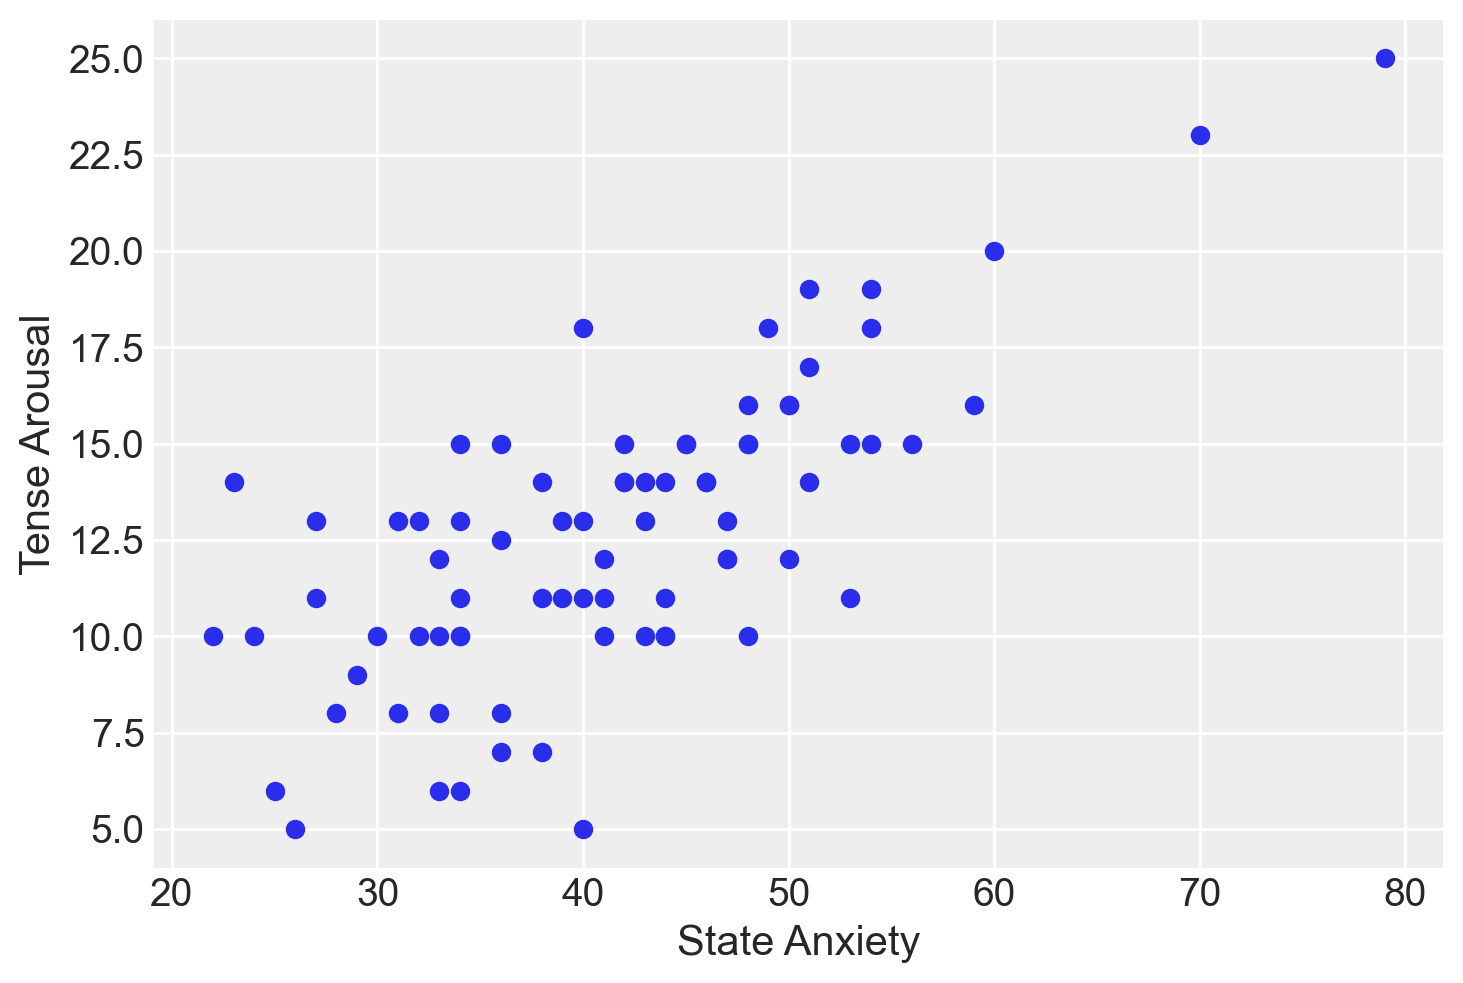

In [33]:
plt.scatter(df["state1"], df["TA1"])
plt.xlabel("State Anxiety")
plt.ylabel("Tense Arousal")
plt.show()

## Minimi Quadrati

Ci poniamo il duplice obiettivo di identificare la retta che meglio si adatta ai dati del diagramma e di valutare la qualità di tale adattamento. In altre parole, vogliamo misurare quanto, in media, i punti del diagramma si discostano dalla retta trovata.

Nel modello di regressione lineare classica, espresso come $y_i = \beta_0 + \beta_1 x_i + e_i$, i coefficienti $\beta_0$ e $\beta_1$ vengono stimati minimizzando la somma dei quadrati degli errori $\epsilon_i$.

Possiamo utilizzare la funzione `linear_regression()` del pacchetto `pingouin` per calcolare i coefficienti del modello seguendo questo approccio:

In [34]:
x = df["state1"]
y = df["TA1"]

lm = pg.linear_regression(x, y)
lm.round(2)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,1.56,1.25,1.25,0.22,0.52,0.52,-0.93,4.04
1,state1,0.27,0.03,9.14,0.00,0.52,0.52,0.21,0.33


Recuperiamo i coefficienti `b0` e `b1` dall'oggetto `lm` creato da `linear_regression()`.

In [18]:
beta = lm["coef"]  # Coefficienti
beta

0    1.555463
1    0.267071
Name: coef, dtype: float64

In [19]:
b0 = beta[0]
b1 = beta[1]

Calcoliamo i valori predetti dal modello di regressione:

In [11]:
yhat = b0 + b1 * x
yhat

0     12.505379
1      8.499312
2      9.834668
3      9.033455
4     14.107806
        ...    
73    12.238308
74    17.579731
75     7.965170
76    10.368810
77    10.368810
Name: state1, Length: 78, dtype: float64

I valori predetti $\hat{y}$ corrispondono alla retta di regressione:

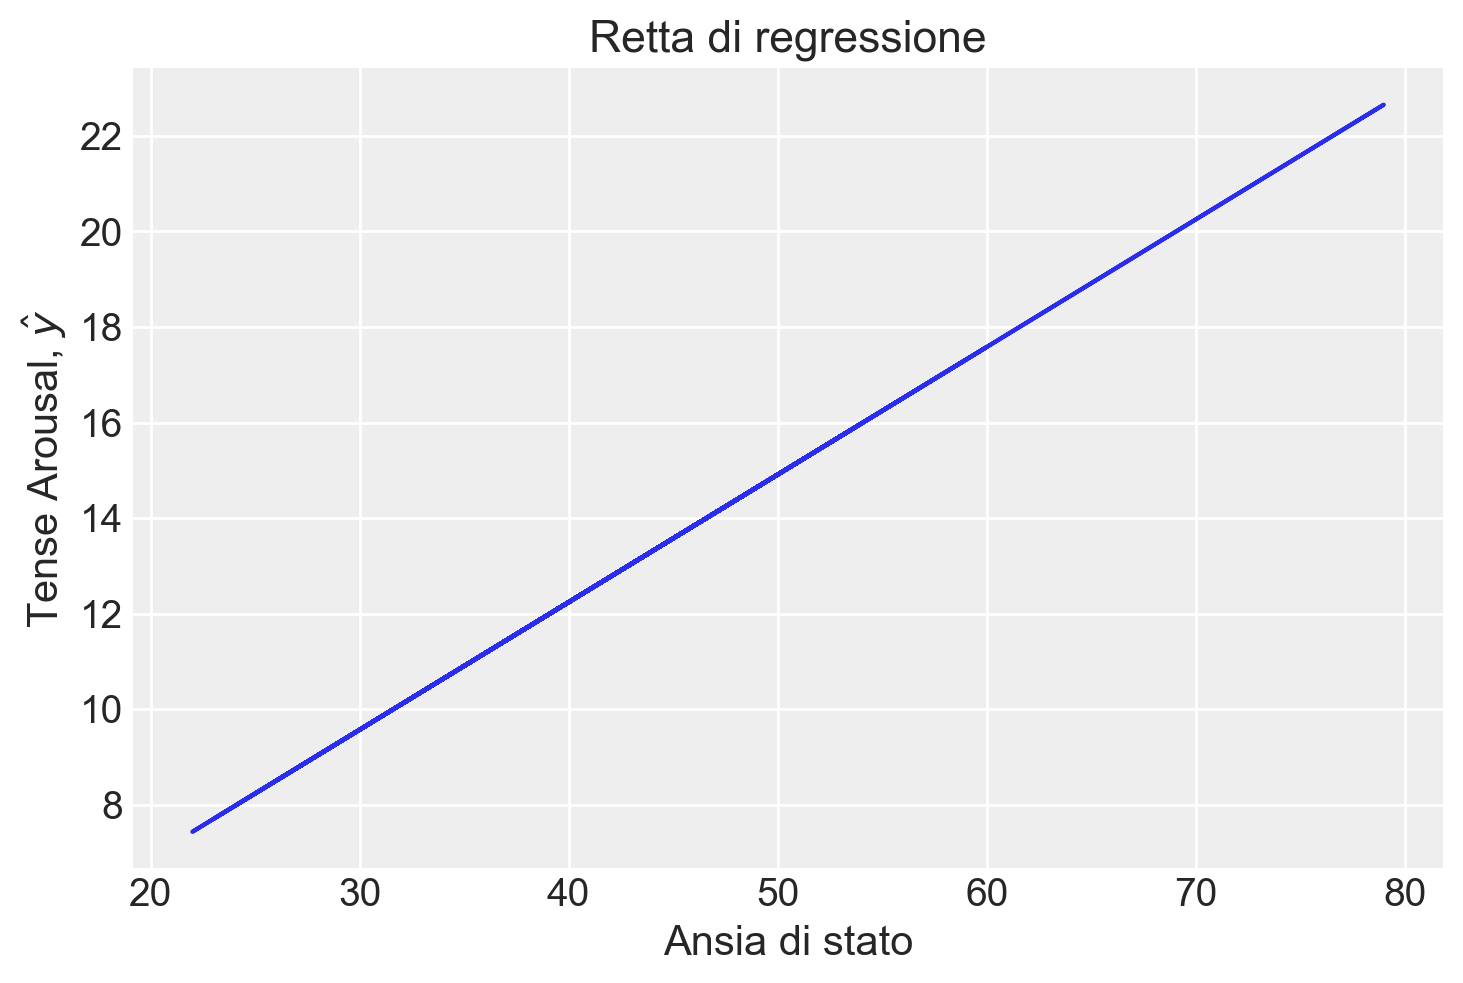

In [12]:
plt.plot(x, yhat)
plt.xlabel("Ansia di stato")
plt.ylabel("Tense Arousal, $\\hat{y}$")
_ = plt.title("Retta di regressione")

Aggiungiamo i dati osservati al grafico.

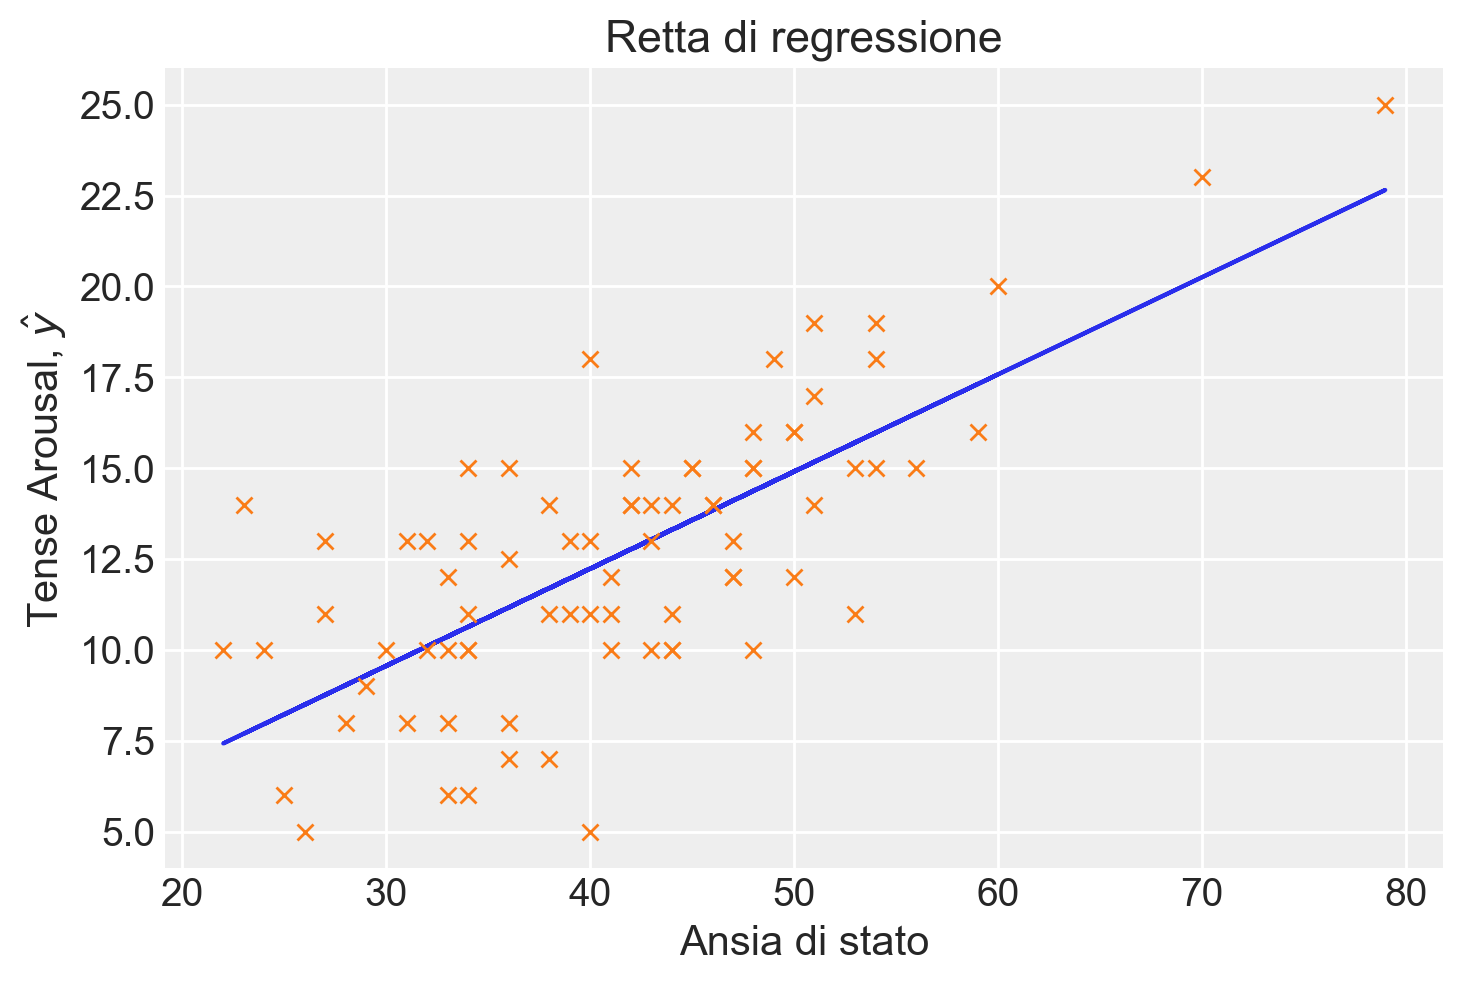

In [13]:
plt.plot(x, yhat)
plt.plot(x, y, "x")
plt.xlabel("Ansia di stato")
plt.ylabel("Tense Arousal, $\\hat{y}$")
_ = plt.title("Retta di regressione")

### Interpretazione

Il coefficiente $\beta_0$ indica il valore atteso della distribuzione condizionata $p(y_i \mid x_i = 0)$. Nel caso presente, indica la media di Tense Arousal quando l'ansia di stato è uguale a 0. Ovviamente questa non è un'informazione di una qualche importanza pratica. Vedremo come migliorare l'interpretabilità dell'intercetta usando una parametrizzazione alternativa dei dati.

Il coefficiente $\beta_1$ indica il cambiamento del valore atteso della variabile dipendente quando la variabile indipendente aumenta di un'unità. Nel caso presente abbiamo che il punteggio di Tense Arousal aumenta in media di 0.27 punti quando l'ansia di stato aumenta di un punto. In una parametrizzazione alternativa, standardizzando la variabile indipendente, $\beta_1$ indicherebbe di quanto varia in media Tense Arousal quando l'ansia di stato aumenta di una deviazione standard.

## Residui

Calcoliamo i residui

$$
e_i = y_i - \hat{y}_i
$$

In [12]:
e = y - yhat

La retta di regressine calcolata con il metodo della massima verosimiglianza ha le seguenti proprietà:

- il valore atteso dei residui è zero,
- i residui sono incorrelati con i valori predetti.

Valutiamo la media dei residui:

In [13]:
np.mean(e)

2.1065770210836304e-15

Calcoliamo la correlazione tra i residui $e$ e i valori predetti $\hat{y}$:

In [14]:
np.corrcoef(e, yhat)[0, 1]

3.7592426344877714e-16

Il modello di regressione bivariato 

$$
y_i = \beta_0 + \beta_1 x_i + e_i
$$

scompone la variabile dipendente $y_i$ in due componenti tra loro incorrelate, una componente deterministica

$$
\hat{y}_i = \beta_0 + \beta_1 x_i 
$$

e una componente aleatoria

$$
e_i = y_i - \hat{y}_i.
$$

In [15]:
df = pd.DataFrame()
df["x"] = x
df["y"] = y
df["yhat"] = yhat
df["e"] = e
df["sum"] = df["yhat"] + df["e"]
df

,x,y,yhat,e,sum
0,41,11.0,12.505379,-1.505379,11.0
1,26,5.0,8.499312,-3.499312,5.0
2,31,8.0,9.834668,-1.834668,8.0
3,28,8.0,9.033455,-1.033455,8.0
4,47,12.0,14.107806,-2.107806,12.0
...,...,...,...,...,...
73,40,13.0,12.238308,0.761692,13.0
74,60,20.0,17.579731,2.420269,20.0
75,24,10.0,7.965170,2.034830,10.0
76,33,10.0,10.368810,-0.368810,10.0


### Errore Standard della Regressione

L'errore standard della regressione rappresenta la stima della deviazione standard dei residui nell'intera popolazione. Questo parametro può essere calcolato attraverso la formula:

$$
\hat{\sigma}_e = \sqrt{\frac{\sum_i (e_i - \bar{e})^2}{n-2}},
$$

dove $ \bar{e} $ indica la media dei residui, che teoricamente è zero dato che si assume che la media degli errori sia zero.

Il denominatore "n-2" deriva dalla perdita di due gradi di libertà, necessaria per la stima dei due coefficienti, $ \beta_0 $ (intercetta) e $ \beta_1 $ (pendenza), che sono utilizzati per calcolare le stime previste $ \hat{y}_i = \beta_0 + \beta_1 x_i $. Questi gradi di libertà vengono sottratti perché ciascun parametro stimato consuma un grado di libertà dal totale disponibile.

Nel caso dell'esempio, la numerosità campionaria è

In [16]:
n = len(x)
n

78

L'errore standard della regressione diventa

In [17]:
np.sqrt(np.sum(e**2) / (n - 2))

2.671556929795855

Questo valore indica che, in media, nella popolazione la distanza tra i valori osservati e la retta di regressione è di 2.67 punti.

Come discusso da {cite}`gelman2020regression`, la radice quadrata media dei residui, $ \frac{1}{n} \sum_{i=1}^n (y_i - (\hat{a} + \hat{b}x_i))^2 $, tende a sottostimare la deviazione standard $\sigma$ dell'errore nel modello di regressione. Questa sottostima è spesso il risultato di un sovradimensionamento, dato che i parametri $a$ e $b$ sono stimati utilizzando gli stessi $n$ punti dati usati anche per calcolare i residui.

La validazione incrociata rappresenta un approccio alternativo per valutare l'errore predittivo che evita alcuni dei problemi legati al sovradimensionamento. La versione più semplice della validazione incrociata è l'approccio leave-one-out, in cui il modello è adattato $n$ volte, escludendo ogni volta un punto dati, adattando il modello ai rimanenti $n-1$ punti dati, e utilizzando questo modello adattato per predire l'osservazione esclusa:
- Per $i = 1, \ldots, n$:
  - Adatta il modello $y = a + bx + \text{errore}$ ai $n-1$ punti dati $(x,y)_j, j \neq i$. Denomina i coefficienti di regressione stimati come $\hat{a}_{-i}, \hat{b}_{-i}$.
  - Calcola il residuo validato incrociato, $ r_{\text{CV}} = y_i - (\hat{a}_{-i} + \hat{b}_{-i} x_i) $.
  - Calcola la stima di $\sigma_{\text{CV}} = \frac{1}{n} \sum_{i=1}^n r_{\text{CV}}^2$.

Per fare un esempio, eseguiamo i passaggi sopra descritti per il modello che predice Tense Arousal dall'ansia di stato. 

In [20]:
# Inizializzazione di un modello di regressione lineare
model = LinearRegression()

# Array per salvare i residui cross-validated
residuals_cv = []

# Loop per la validazione incrociata leave-one-out
for i in range(len(df)):
    # Dati di training escludendo l'i-esimo punto
    X_train = df.loc[df.index != i, ["x"]]
    y_train = df.loc[df.index != i, "y"]

    # Dati di test
    X_test = df.loc[[i], ["x"]]
    y_test = df.loc[i, "y"]

    # Addestramento del modello
    model.fit(X_train, y_train)

    # Predizione sull'i-esimo punto
    y_pred = model.predict(X_test)

    # Calcolo del residuo validato incrociato
    residual_cv = y_test - y_pred[0]
    residuals_cv.append(residual_cv**2)

# Calcolo di sigma_cv
sigma_cv = np.sqrt(np.mean(residuals_cv))

print("Stima di σ_CV:", sigma_cv)

Stima di σ_CV: 2.7114997423207527


Nel caso dei dati analizzati, si osserva che la stima ottenuta attraverso la validazione incrociata è leggermente superiore rispetto a quella calcolata usando la formula 
$
\hat{\sigma}_e = \sqrt{\frac{\sum_i (e_i - \bar{e})^2}{n-2}}
$.
Questo incremento, sebbene minimo, riflette le differenze metodologiche tra i due approcci di stima dell'errore standard.

### Parametrizzazione Alternativa

Per consentire una migliore interpretazione dell'intercetta, centriamo i valori della variabile indipendente.

In [33]:
x = df["state1"]
y = df["TA1"]

xc = x - np.mean(x)
np.mean(xc)

-1.8219044506669234e-15

Eseguiamo l'analisi di regressione.

In [32]:
lm2 = pg.linear_regression(xc, y)
lm2.round(2)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,12.62,0.30,41.73,0.0,0.52,0.52,12.02,13.22
1,state1,0.27,0.03,9.14,0.0,0.52,0.52,0.21,0.33


Notiamo che la stima della pendenza della retta di regressione è rimasta immutata, mentre cambia il coefficiente $\beta_0$. Nel caso in cui la variabile indipendente sia centrata, il coefficiente $\beta_0$ rappresenta il valore atteso della variabile dipendente quando la variabile indipendente assume il suo valore medio.

Nel caso presente, il valore 12.62 indica la media di Tense Arousal quando l'ansia di stato assume il valore medio nel campione.

Adesso standardizziamo sia la variabile dipendente che la variabile indipendente.

In [46]:
# Standardizzazione
zx = standardize(x)
zy = standardize(y)

In [47]:
print(np.mean(zx), np.std(zx))

-2.049642507000289e-16 1.0


In [48]:
print(np.mean(zy), np.std(zy))

-1.25255930983351e-16 1.0


In [49]:
lm3 = pg.linear_regression(zx, zy)
lm3.round(2)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-0.00,0.08,-0.00,1.0,0.52,0.52,-0.16,0.16
1,state1,0.72,0.08,9.14,0.0,0.52,0.52,0.57,0.88


Dopo aver standardizzato entrambe le variabili, i coefficienti di regressione possono essere interpretati nel seguente modo:

- **$\beta_0$ = 0**: Questo si verifica perché la retta di regressione, calcolata attraverso il metodo dei minimi quadrati (ML), interseca il punto delle medie delle variabili standardizzate, ovvero $(\bar{X}, \bar{Y})$.
- **$\beta_1$**: Rappresenta la variazione media della variabile dipendente, espressa in termini di deviazioni standard, per ogni aumento di una deviazione standard nella variabile indipendente.

### Derivazione delle stime dei minimi quadrati

L'approccio classico al modello di regresione fa uso del metodo dei minimi quadrati per trovare la retta che meglio si adatta a un insieme di dati. L'obiettivo è minimizzare la somma dei quadrati delle differenze (residui) tra i valori osservati e quelli predetti dal modello lineare.

Supponiamo di avere un insieme di dati $(x_i, y_i)$, dove $i = 1, 2, \dots, n$. Il modello lineare si esprime come:

$$
y_i = \alpha + \beta x_i + \epsilon_i,
$$

dove:

- $\alpha$ è l'intercetta,
- $\beta$ è il coefficiente angolare (pendenza),
- $\epsilon_i$ è il residuo, ossia l'errore associato al punto $i$.

Il metodo dei minimi quadrati mira a minimizzare la somma dei quadrati dei residui $\epsilon_i$:

$$
S(\alpha, \beta) = \sum_{i=1}^n \epsilon_i^2 = \sum_{i=1}^n (y_i - (\alpha + \beta x_i))^2
$$

Geometricamente, trovare i valori di $\alpha$ e $\beta$ che minimizzano la funzione $S(\alpha, \beta)$ significa trovare il punto in cui la funzione è piatta, ossia dove la sua pendenza è zero. Questo si fa calcolando le derivate parziali di $S(\alpha, \beta)$ rispetto a $\alpha$ e $\beta$, e ponendole uguali a zero:

$$
\frac{\partial S}{\partial \alpha} = 0 \quad \text{e} \quad \frac{\partial S}{\partial \beta} = 0.
$$

Risolvendo questo sistema di equazioni, si trovano le espressioni per $\alpha$ e $\beta$:

$$
\beta = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^n (x_i - \bar{x})^2},
$$

$$
\alpha = \bar{y} - \beta \bar{x},
$$

dove $\bar{x}$ e $\bar{y}$ sono le medie dei valori $x_i$ e $y_i$ rispettivamente.

Per chiarire, ora consideriamo il caso in cui i dati sono standardizzati. Quando i dati sono standardizzati (cioè $x_i$ e $y_i$ hanno media 0 e deviazione standard 1), l'intercetta $\alpha$ è 0, quindi il modello diventa:

$$
y_i = \beta x_i + \epsilon_i
$$

Di conseguenza, dobbiamo solo stimare $\beta$.

Ecco come eseguire una simulazione in Python per questo caso:

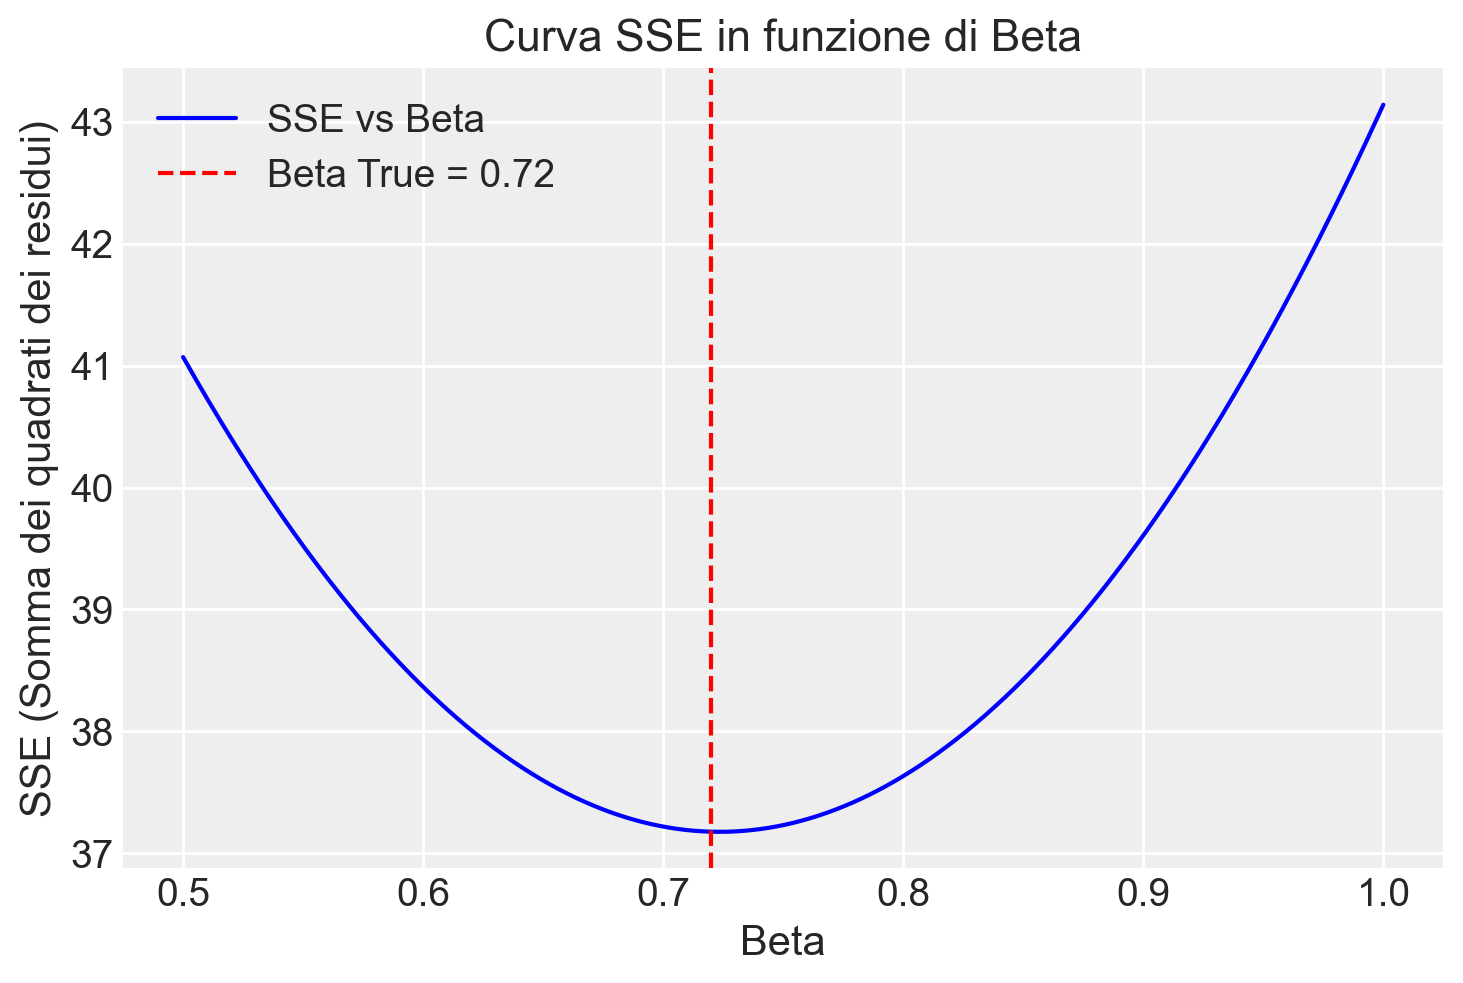

Valore di beta stimato con la formula dei minimi quadrati: 0.72
Valore stimato di beta (minimo SSE): 0.7232232232232232


In [44]:
# Serie di valori di beta tra 0 e 1
beta_values = np.linspace(0.5, 1, 1000)

# Calcolo della somma dei quadrati dei residui (SSE) per ciascun valore di beta
SSE = []
for beta in beta_values:
    residuals = zy - beta * zx
    SSE.append(np.sum(residuals**2))

# Convertiamo SSE in un array numpy per maggiore facilità nella visualizzazione
SSE = np.array(SSE)

beta_true = 0.72 # trovato da pingouin

# Visualizzazione della curva SSE in funzione di beta
plt.plot(beta_values, SSE, label="SSE vs Beta", color="blue")
plt.axvline(beta_true, color="red", linestyle="--", label=f"Beta True = {beta_true}")
plt.xlabel("Beta")
plt.ylabel("SSE (Somma dei quadrati dei residui)")
plt.title("Curva SSE in funzione di Beta")
plt.legend()
plt.show()

# Troviamo il valore di beta che minimizza SSE
beta_min_index = np.argmin(SSE)
beta_min = beta_values[beta_min_index]

print(f"Valore di beta stimato con la formula dei minimi quadrati: {beta_true}")
print(f"Valore stimato di beta (minimo SSE): {beta_min}")

## Metodo della Massima Verosimiglianza

Dopo aver discusso il metodo dei minimi quadrati, possiamo affrontare il metodo della massima verosimiglianza, che in molti casi porta agli stessi risultati ma con un approccio leggermente diverso.

#### Connessione con il Metodo dei Minimi Quadrati

Nel contesto della regressione lineare, se gli errori del modello sono indipendenti e distribuiti normalmente, cioè se $y_i \sim \text{Normale}(\alpha + \beta x_i, \sigma^2)$ per ogni $i$, allora la stima dei parametri ottenuta con il metodo dei minimi quadrati coincide con quella ottenuta usando il metodo della massima verosimiglianza. Questo significa che i valori di $\alpha$ e $\beta$ che minimizzano la somma dei quadrati degli errori residui sono anche quelli che massimizzano la probabilità di osservare i dati dati quei parametri.

#### La Funzione di Verosimiglianza

In un modello di regressione, la funzione di verosimiglianza è definita come la probabilità (o densità di probabilità) di osservare i dati effettivi in funzione dei parametri e dei predittori del modello. In altre parole, dato un insieme di parametri $\alpha$, $\beta$ e $\sigma$, la funzione di verosimiglianza ci dice quanto è probabile osservare i dati $y$ dati quei parametri.

Matematicamente, la funzione di verosimiglianza per un modello di regressione lineare è espressa come:

$$
p(y|\alpha, \beta, \sigma, X) = \prod_{i=1}^{n} N(y_i|\alpha + \beta x_i, \sigma^2).
$$

Qui, $N(\cdot|\cdot, \cdot)$ rappresenta la funzione di densità della distribuzione normale.

Questa formula indica che la verosimiglianza totale è il prodotto delle densità di probabilità per ciascun punto dati $y_i$, considerando che ogni $y_i$ segue una distribuzione normale con media $\alpha + \beta x_i$ e varianza $\sigma^2$.

#### Minimizzare i Residui Quadratici

Un'analisi della funzione di verosimiglianza mostra che massimizzare questa funzione equivale a minimizzare la somma dei quadrati dei residui, proprio come si fa nel metodo dei minimi quadrati. Questo perché la funzione di densità normale $N(y_i|\alpha + \beta x_i, \sigma^2)$ ha un massimo quando il valore di $y_i$ è vicino alla media prevista $\alpha + \beta x_i$, e il prodotto delle densità è massimizzato quando i residui sono minimi.

#### Differenza nella Stima di $\sigma$

C'è una piccola differenza nella stima della deviazione standard $\sigma$ tra i due metodi. Nel metodo della massima verosimiglianza, la stima di $\sigma$ viene calcolata come:

$$
\hat{\sigma}^2 = \frac{1}{n} \sum_{i=1}^{n} \left(y_i - (\hat{\alpha} + \hat{\beta} x_i)\right)^2
$$

In questo caso, il denominatore è $n$, mentre nel metodo dei minimi quadrati il denominatore è $n-2$, che riflette l'aggiustamento per i gradi di libertà.

In sintesi, il metodo della massima verosimiglianza trova i parametri che rendono i dati osservati i più probabili, dato il modello. Quando gli errori sono normalmente distribuiti, questo approccio porta agli stessi risultati del metodo dei minimi quadrati, ma con un'interpretazione basata sulla probabilità. 

## Coefficiente di Determinazione

I modelli lineari, sia quelli stimati con il metodo dei minimi quadrati che quelli ottenuti tramite massima verosimiglianza, permettono una decomposizione della varianza totale della variabile dipendente $y$ in due componenti indipendenti: la devianza spiegata e la devianza residua. Questa decomposizione deriva dal teorema della decomposizione della devianza, come descritto nell'@sec-theo-deviance-decomposition.

La *devianza spiegata* (DS) rappresenta la parte della varianza totale che è attribuibile al modello, ed è definita come:

$$
DS = \sum_{i=1}^n (\hat{y}_i - \bar{y})^2,
$$

dove $\hat{y}_i$ è il valore predetto dal modello per l'osservazione $i$, e $\bar{y}$ è la media delle osservazioni di $y$. 

La *devianza residua* (DR), invece, rappresenta la parte della varianza totale che non è spiegata dal modello, ovvero l'errore, ed è calcolata come:

$$
DR = \sum_{i=1}^n (y_i - \hat{y}_i)^2.
$$

La somma delle due componenti, ovvero la devianza spiegata e la devianza residua, è pari alla *devianza totale* (DT):

$$
DT = \sum_{i=1}^n (y_i - \bar{y})^2.
$$

Il *coefficiente di determinazione* $R^2$ è definito come il rapporto tra la devianza spiegata e la devianza totale:

$$
R^2 = \frac{DS}{DT}.
$$

Il coefficiente di determinazione $R^2$ fornisce una misura della proporzione della varianza totale di $y$ che viene spiegata dal modello di regressione. Un valore di $R^2$ vicino a 1 indica che il modello spiega una grande parte della variabilità osservata nei dati, mentre un valore vicino a 0 suggerisce che il modello spiega poco della variabilità della variabile dipendente. 

Questo coefficiente è particolarmente utile per valutare l'adeguatezza di un modello lineare, permettendo di comprendere quanto del fenomeno studiato viene catturato dalle variabili indipendenti incluse nel modello. Tuttavia, è importante ricordare che un alto valore di $R^2$ non implica necessariamente che il modello sia il migliore in senso assoluto; altri fattori come la complessità del modello e la presenza di potenziali errori di specificazione devono essere considerati nella valutazione complessiva del modello.

## Modello di Regressione Bayesiano

L'approccio bayesiano si distingue dal metodo dei minimi quadrati o dalla massima verosimiglianza, poiché non si limita a determinare i parametri che meglio si adattano ai dati osservati secondo un criterio fisso. Al contrario, integra queste stime con informazioni a priori sui parametri stessi, combinando la verosimiglianza dei dati con una distribuzione a priori che rappresenta le ipotesi o le conoscenze preesistenti. In questo modo, l'inferenza bayesiana diventa un processo di aggiornamento delle credenze: la distribuzione a posteriori dei parametri riflette la conoscenza aggiornata dopo aver osservato i dati. Mentre i metodi classici forniscono stime puntuali, l'inferenza bayesiana genera distribuzioni a posteriori che descrivono la probabilità di ogni possibile valore dei parametri, tenendo conto dell'incertezza complessiva nel modello.

Nel contesto di un modello lineare bayesiano, si utilizzano le seguenti convenzioni: le variabili di risposta sono indicate con $y$, le variabili predittive (note anche come covariate o caratteristiche) con $x$, e l'indice di osservazione con $n$, che va da 1 al numero totale di osservazioni $N$. Con questa notazione, la verosimiglianza di un semplice modello lineare (gaussiano) si può esprimere come:

$$
y_n \sim \text{Normale}(\mu_n, \sigma),
$$

$$
\mu_n = b_0 + b_1 x_n.
$$

In questo caso, la distribuzione normale univariata è definita in termini di media $\mu$ e deviazione standard $\sigma$.

Nel modello bayesiano lineare, i parametri principali sono l'intercetta $b_0$ e il coefficiente $b_1$ associato alla variabile predittiva $x$. Questi parametri insieme formano il predittore lineare $\mu$. Il parametro $\sigma$, invece, rappresenta la deviazione standard residua, ovvero la variabilità che non può essere spiegata dal modello lineare e che cattura l'errore o il "rumore" presente nei dati.

Ad esempio, se si vuole modellare la relazione tra ansia di stato ($x$) e Tense Arousal ($y$), l'approccio bayesiano permette di strutturare il modello in modo simile a quanto fatto con i metodi classici. Anche qui, si assume che gli errori siano indipendenti tra loro, distribuiti normalmente con media zero e varianza costante $\sigma^2$. Tuttavia, l'approccio bayesiano consente anche di specificare distribuzioni a priori per i parametri del modello ($b_0$, $b_1$ e $\sigma$), che rappresentano la conoscenza iniziale sui parametri prima di osservare i dati.

Dopo aver raccolto i dati, si utilizza il teorema di Bayes per aggiornare queste distribuzioni a priori e ottenere le distribuzioni a posteriori dei parametri. Le distribuzioni a posteriori combinano l'informazione fornita dai dati con le credenze iniziali, offrendo così stime dei parametri che riflettono sia l'evidenza empirica che le conoscenze preesistenti, garantendo un'inferenza più robusta e flessibile.

### Verosimiglianza

Il modello di verosimiglianza per descrivere la relazione tra $x$ (ansia di stato) e $y$ (Tense Arousal) assume che:

$$ y \sim \text{Normale}(\alpha + \beta x, \sigma) $$

Questo implica che i valori osservati di $y$ sono distribuiti normalmente attorno alla retta di regressione $\alpha + \beta x$, con una deviazione standard $\sigma$. In altre parole, ogni osservazione di $y$ è una combinazione lineare dell'intercetta $\alpha$, del coefficiente $\beta$ che moltiplica la variabile $x$, e di un termine di errore normalmente distribuito.

### Distribuzioni a Priori

Per implementare l'approccio bayesiano, definiamo delle distribuzioni a priori per i parametri $\alpha$, $\beta$, e $\sigma$. In una prima versione del modello, possiamo utilizzare delle distribuzioni a priori uniformi, che esprimono una mancanza di conoscenza specifica o una neutralità nelle credenze iniziali sui valori di questi parametri.

### Distribuzioni a Posteriori

Le distribuzioni a posteriori sono ottenute combinando la verosimiglianza con le distribuzioni a priori mediante il teorema di Bayes. Queste distribuzioni a posteriori riflettono il nostro stato di conoscenza sui parametri dopo aver osservato i dati, incorporando sia le informazioni contenute nei dati che le credenze iniziali espresse dalle distribuzioni a priori. L'approccio bayesiano, quindi, non solo fornisce stime dei parametri, ma anche una quantificazione dell'incertezza associata a queste stime, rendendolo particolarmente utile in situazioni con dati limitati o incertezza significativa.

Questa metodologia ci permette di modellare e comprendere in modo più completo e robusto la relazione tra ansia di stato e Tense Arousal, integrando informazioni preesistenti con nuove evidenze empiriche.

In sintesi, il modello di regressione bayesiano può essere riassunto come segue. La verosimiglianza è data da:

$$
y_i \sim \text{Normal}(\alpha + \beta \cdot x_i, \sigma).
$$

In una prima formulazione del modello, possiamo utilizzare prior uniformi per ciascuno dei parametri $\alpha$, $\beta$ e $\sigma$:

$$
\alpha \sim \text{Uniform}(-\infty, \infty),
$$
$$
\beta \sim \text{Uniform}(-\infty, \infty),
$$
$$
\sigma \sim \text{Uniform}(0, \infty).
$$

### Codice Stan

Il codice Stan che implementa il modello descritto in precedenza è contenuto nel file `arousal_model_1.stan`. Compiliamo e stampiamo il modello.

In [20]:
stan_file = os.path.join(project_directory, 'stan', 'arousal_model1.stan')
model1 = CmdStanModel(stan_file=stan_file)
print(model1.code())

data {
  int<lower=1> N; // numero totale di osservazioni 
  vector[N] y; // variabile di risposta
  vector[N] x; // variabile predittore
}
parameters {
  real alpha; // intercetta
  real beta; // coefficiente angolare
  real<lower=0> sigma; // deviazione standard residua
}
model {
  // verosimiglianza
  y ~ normal(alpha + beta * x, sigma);
}



Si osservi che, in questa prima istanziazione del modello bayesiano, non avendo specificato le distribuzioni a priori per i parametri $\alpha$, $\beta$ e $\sigma$, Stan assume distribuzioni a priori uniformi per questi parametri.

Sistemiamo i dati in un dizionario come richiesto dal modello Stan.

In [21]:
stan_data = {
    "N": len(df["TA1"]),
    "x": df["state1"],
    "y": df["TA1"]
}
print(stan_data)

{'N': 78, 'x': 0     41
1     26
2     31
3     28
4     47
      ..
73    40
74    60
75    24
76    33
77    33
Name: state1, Length: 78, dtype: int64, 'y': 0     11.0
1      5.0
2      8.0
3      8.0
4     12.0
      ... 
73    13.0
74    20.0
75    10.0
76    10.0
77     6.0
Name: TA1, Length: 78, dtype: float64}


Eseguiamo il campionamento MCMC.

In [22]:
fit1 = model1.sample(
    data=stan_data,
    iter_warmup=1_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False
)

Esaminiamo le distribuzioni a posteriori dei parametri.

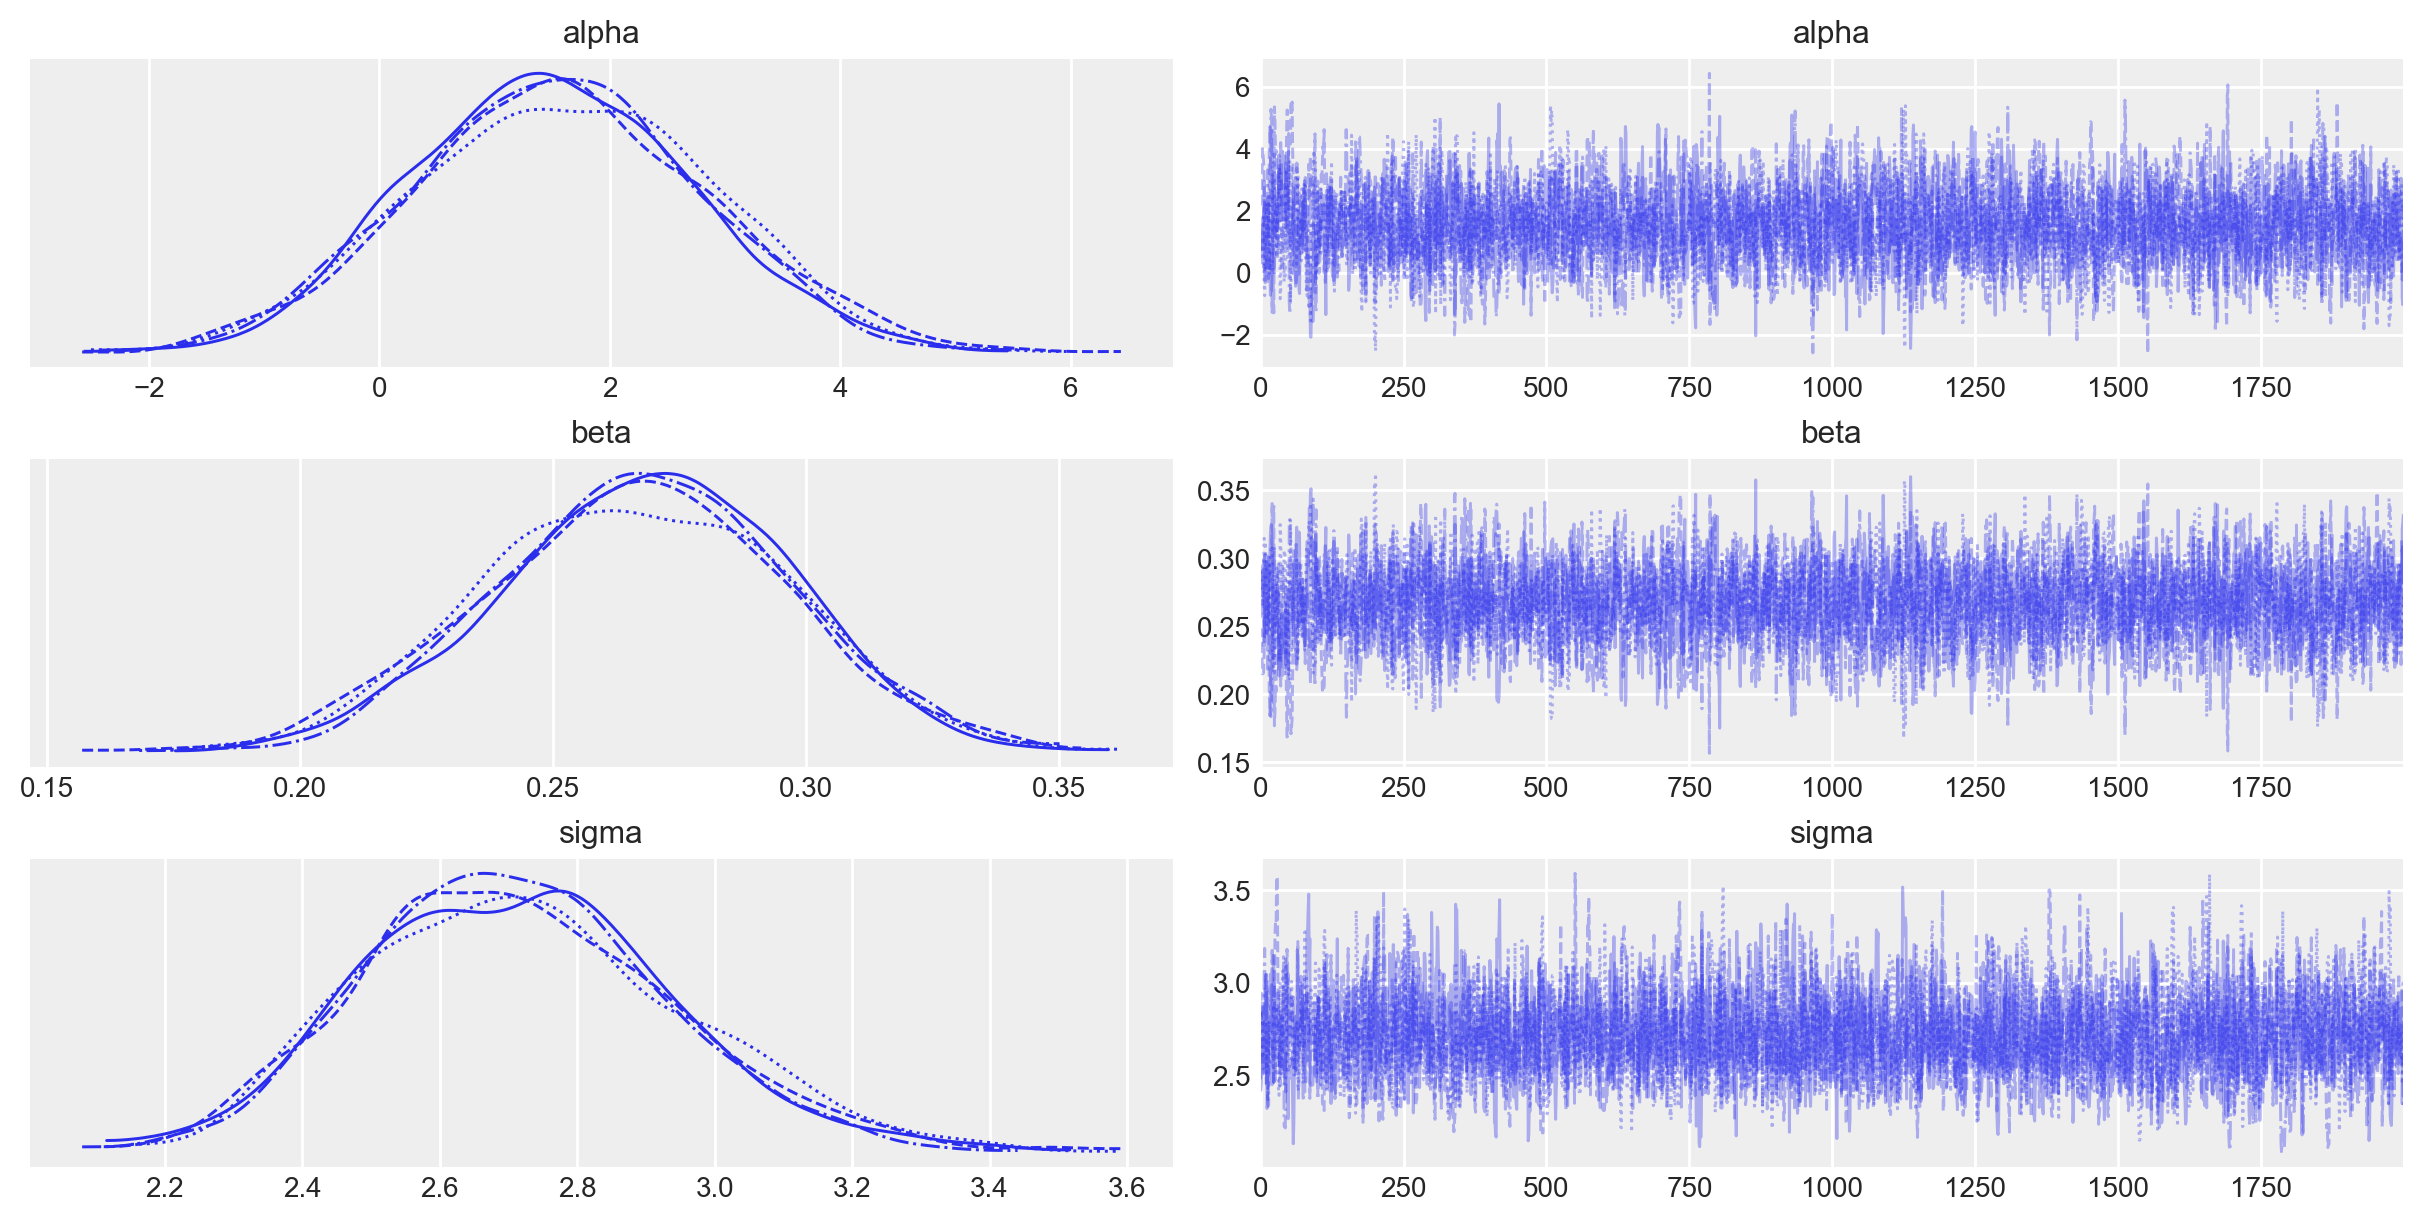

In [23]:
_ = az.plot_trace(fit1, var_names=(["alpha", "beta", "sigma"]))

Le tracce delle quattro catene indicano che sono ben mescolate e convergono verso una distribuzione stazionaria, segnalando una buona esplorazione dello spazio dei parametri. Questo è evidenziato dal fatto che le tracce non mostrano trend evidenti e oscillano intorno a un valore centrale, suggerendo che le catene hanno raggiunto l'equilibrio.

La forma della distribuzione a posteriori, visibile nei grafici a densità, appare approssimativamente gaussiana per ciascun parametro (`alpha`, `beta`, e `sigma`). Questo suggerisce che, dato il modello e i dati, le stime a posteriori sono stabili e ben definite, con una concentrazione delle probabilità attorno ai valori medi e una simmetria che riflette una distribuzione normale.

In sintesi, i grafici di traccia indicano una buona convergenza e una distribuzione a posteriori stabile e ben definita, rafforzando la fiducia nelle stime bayesiane ottenute.

L'oggetto `fit` generato da `cmdstanpy` appartiene alla classe `cmdstanpy.stanfit.mcmc.CmdStanMCMC`. Questo oggetto è funzionalmente equivalente a un oggetto della classe `InferenceData`, consentendo la sua manipolazione tramite le funzioni offerte da ArviZ. Procediamo quindi con l'esame di un sommario delle distribuzioni a posteriori dei parametri del modello lineare.

In [24]:
az.summary(fit1, var_names=(["alpha", "beta", "sigma"]), hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.552,1.256,-0.859,3.816,0.026,0.019,2395.0,2748.0,1.0
beta,0.267,0.029,0.213,0.323,0.001,0.000,2436.0,2858.0,1.0
sigma,2.716,0.227,2.314,3.149,0.004,0.003,3410.0,3273.0,1.0


- **Alpha (Intercetta):** La stima media di `alpha` è 1.552, con un intervallo di credibilità (HDI - Highest Density Interval) al 3% e 97% che va da -0.859 a 3.816. Questo significa che, date le informazioni disponibili e il modello specificato, c'è una probabilità del 94% che l'intercetta reale si trovi all'interno di questo intervallo. L'intercetta corrisponde al valore atteso di Tense Arousal quando l'ansia di stato vale 0.
  
- **Beta (Coefficiente angolare):** La stima media di `beta` è 0.267. Anche qui, l'intervallo di credibilità al 94% va da 0.213 a 0.323, suggerendo che è molto probabile che l'effetto del predittore `x` sulla variabile di risposta `y` sia positivo e compreso in questo intervallo. La pendenza $\beta$ ci informa sull'incremento atteso di Tense Arousal quando l'ansia di stato aumenta di un'unità.

- **Sigma (Deviazione standard residua):** La stima media di `sigma` è 2.716, con un intervallo di credibilità da 2.314 a 3.149. Questa è una misura della variabilità residua, ovvero la deviazione standard degli errori rispetto alla linea di regressione.

La colonna `mean` dell'output riporta la media della distribuzione a posteriori di ciasccun parametro, mentre nella colonna `sd` troviamo una misura di dispersione della distribuzione a posteriori del parametro, ovvero la quantificazione dell'intertezza della stima a posteriori. In pratica è la deviazione standard della distribuzione a posteriori, ovvero la radice quadrata della varianza dei campioni della distribuzione a posteriori del parametro.

Supponiamo di avere $S$ campioni per il parametro $\theta$. Questi campioni possono essere denotati come $\theta_1, \theta_2, \dots, \theta_S$. La media campionaria (o stima puntuale bayesiana) del parametro $\theta$ si calcola come:

$$
\bar{\theta} = \frac{1}{S} \sum_{i=1}^{S} \theta_i.
$$

La deviazione standard della distribuzione a posteriori, che è ciò che è indicato con `sd`, si calcola come la radice quadrata della varianza campionaria dei campioni posteriori:

$$
\text{Var}(\theta) = \frac{1}{S-1} \sum_{i=1}^{S} (\theta_i - \bar{\theta})^2,
$$

$$
\text{sd}(\theta) = \sqrt{\text{Var}(\theta)}.
$$

In sintesi, `sd` è calcolato come la deviazione standard dei campioni ottenuti dalla distribuzione a posteriori di un parametro.

Le altre colonne sono le seguenti.

- **HDI (Intervallo di Massima Densità):** Questo intervallo rappresenta la regione più densa dell'intera distribuzione a posteriori, contenente il 94% delle probabilità. È l'equivalente bayesiano dell'intervallo di confidenza, ma con un'interpretazione probabilistica diretta.

- **R_hat:** È un indicatore di convergenza per le catene di Markov Monte Carlo (MCMC). Un valore di `R_hat` prossimo a 1 segnala che la catena è probabilmente convergente, suggerendo che le stime a posteriori sono affidabili.

- **ESS (Dimensione Campionaria Effettiva):** Indica l'equivalente di un campione indipendente in un'analisi MCMC, valutando quanto efficacemente i campioni generati dalla catena rappresentano la distribuzione a posteriori.

Infine, `mcse_mean` che `mcse_sd` sono misure che valutano la precisione delle stime ottenute tramite MCMC, quantificando quanto queste stime possono variare a causa della natura stocastica del processo di campionamento.

- **mcse_mean (Monte Carlo Standard Error of the Mean):** Questo valore rappresenta l'errore standard Monte Carlo associato alla stima della media del parametro. In altre parole, `mcse_mean` quantifica l'incertezza introdotta dal processo di campionamento MCMC stesso. Un valore basso indica che la catena di Markov Monte Carlo ha fornito una stima della media del parametro con un'alta precisione.

- **mcse_sd (Monte Carlo Standard Error of the Standard Deviation):** Analogamente, `mcse_sd` è l'errore standard Monte Carlo associato alla stima della deviazione standard della distribuzione a posteriori del parametro. Questo valore misura l'incertezza nella stima della dispersione del parametro, dovuta al processo di campionamento MCMC. Anche qui, un valore basso indica che la stima della deviazione standard è stabile e precisa.

Possiamo confrontare i valori ottenuti con l'approccio bayesiano con quelli trovati usando la procedura di massima verosimiglianza.

In [75]:
lm = pg.linear_regression(df["state1"], df["TA1"])
lm.round(2)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,1.56,1.25,1.25,0.22,0.52,0.52,-0.93,4.04
1,state1,0.27,0.03,9.14,0.00,0.52,0.52,0.21,0.33


La somiglianza tra le due soluzioni indica che, quando usiamo dei prior uniformi per i parametri,  i due approcci producono risultati sostanzialmente equivalenti.

L'interpretazione del significato dei parametri è la stessa anche per l'approccio frequentista: 

- L'intercetta rappresenta il valore atteso della variabile di risposta `TA1` quando il predittore `state1` è pari a zero. 
- Il coefficiente `beta` rappresenta la variazione attesa nella variabile di risposta `TA1` per ogni unità di incremento in `state1`. 

Ci sono però delle differenze sostanziali nell'interpretazione dell'incertezza associata alle stime dei parametri.

- **Stima Puntuale vs Distribuzione a Posteriori:**
  - **Frequentista:** Le stime di `alpha` e `beta` sono considerate come valori puntuali, ottenuti attraverso il metodo dei minimi quadrati. Gli errori standard associati a queste stime forniscono un'indicazione della variabilità delle stime se ripetessimo il campionamento molte volte.
  - **Bayesiano:** Le stime di `alpha` e `beta` sono presentate come distribuzioni a posteriori. La media di queste distribuzioni può essere considerata la stima puntuale, ma l'intera distribuzione riflette la nostra incertezza attorno a queste stime, basata sia sui dati osservati che sulle informazioni a priori.

- **Intervallo di Confidenza vs Intervallo Credibile:**
  - **Frequentista:** L'intervallo di confidenza al 95% indica che, se ripetessimo l'esperimento molte volte, il 95% di tali intervalli conterrà il vero valore del parametro. Questo intervallo si basa sulla stima puntuale e sull'assunzione di distribuzione normale degli errori.
  - **Bayesiano:** L'intervallo credibile al 94% (ad esempio l'HDI - Highest Density Interval) rappresenta la probabilità che il parametro si trovi entro quell'intervallo dato il modello, i dati osservati e le informazioni a priori. È un'intervallo che ha una diretta interpretazione probabilistica.

- **p-value vs Significato Bayesiano:**
  - **Frequentista:** Il p-value è utilizzato per testare l'ipotesi nulla che il coefficiente sia uguale a zero. Un p-value molto basso (come in questo caso per `beta`) suggerisce che c'è una forte evidenza contro l'ipotesi nulla.
  - **Bayesiano:** In un'analisi bayesiana, non si fa riferimento a p-value; l'accento è posto sulla distribuzione a posteriori e sull'intervallo credibile, che forniscono una comprensione diretta dell'incertezza attorno ai parametri senza bisogno di test di ipotesi tradizionali.

In sintesi,

- **Interpretazione delle stime:** Nell'approccio frequentista, le stime dei parametri sono valori puntuali accompagnati da un intervallo di confidenza che riflette la variabilità campionaria. Nell'approccio bayesiano, ogni parametro è rappresentato come una distribuzione a posteriori che incorpora sia i dati osservati sia le informazioni a priori.
  
- **Gestione dell'incertezza:** L'approccio frequentista usa errori standard e intervalli di confidenza, mentre l'approccio bayesiano utilizza l'intera distribuzione a posteriori per descrivere l'incertezza.
- **Probabilità e significatività:** Nell'approccio frequentista, il p-value è cruciale per determinare la significatività statistica, mentre nell'approccio bayesiano si utilizza l'intervallo credibile e la probabilità a posteriori per descrivere quanto è probabile un parametro dato i dati e le informazioni a priori.

## Interpretare i coefficienti di regressione come confronti, non come effetti

@gelman2021regression sottolineano che i coefficienti di regressione sono spesso chiamati "effetti", ma questa terminologia può essere fuorviante. Gli effetti, infatti, sono conseguenze di una relazione causale. Tuttavia, ciò che il modello di regressione stima non è necessariamente un effetto causale, ma piuttosto un pattern osservazionale. In particolare, quello che viene osservato è che la media della variabile $y$ nella sottopopolazione con $X = x + 1$ è $b$ volte maggiore o minore (a seconda del segno di $\beta$) rispetto alla media della sottopopolazione con $X = x$.

La regressione è uno strumento matematico utilizzato principalmente per fare previsioni. I coefficienti di regressione devono essere sempre interpretati come confronti medi. Solo in circostanze specifiche, quando la regressione descrive un processo causale ben definito, è possibile interpretarli come effetti. Tuttavia, questa interpretazione causale deve essere giustificata dal disegno dello studio e non può essere derivata unicamente dall'uso del modello statistico.

## Ricodifica dei dati

L'intercetta ($\alpha$) rappresenta il valore atteso di Tense Arousal quando l'ansia di stato è pari a 0. Tuttavia, poiché l'ansia di stato è misurata su una scala ad intervalli, l'origine è arbitraria e non rappresenta l'assenza della proprietà. Lo stesso vale per la variabile Tense Arousal. Per entrambe le variabili, inoltre, anche l'unità di misura è arbitraria.

In queste circostanze, una trasformazione utile è la standardizzazione. La standardizzazione fa sì che il valore 0 corrisponda alla media campionaria e che l'unità di misura sia una deviazione standard.

Quando standardizziamo l'ansia di stato, il valore 0 della variabile standardizzata corrisponde alla media della variabile originale. Dato che la retta di regressione passa per il punto $(\bar{x}, \bar{y})$, utilizzando i valori standardizzati di $x$ e $y$, la nuova intercetta ($\alpha$) sarà 0. La pendenza ($\beta$) avrà un'interpretazione utile: nel caso di dati standardizzati, la pendenza stima l'incremento (o decremento) atteso di $y$ quando $x$ aumenta di una deviazione standard.

In [25]:
# Calcolo della media e della deviazione standard di state1
mean_state1 = np.mean(df["state1"])
std_state1 = np.std(df["state1"])
# Standardizzazione 
df["state1_z"] = (df["state1"] - mean_state1) / std_state1

# Calcolo della media e della deviazione standard di TA1
mean_ta1 = np.mean(df["TA1"])
std_ta1 = np.std(df["TA1"])
# Standardizzazione 
df["ta1_z"] = (df["TA1"] - mean_ta1) / std_ta1

/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/ipykernel_79156/3940630615.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["state1_z"] = (df["state1"] - mean_state1) / std_state1
/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/ipykernel_79156/3940630615.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ta1_z"] = (df["TA1"] - mean_ta1) / std_ta1


Creiamo il dizionario dei dati con le nuove variabli standardizzate.

In [26]:
stan_data2 = {
    "N": len(df["state1_z"]), 
    "x": df["state1_z"], 
    "y": df["ta1_z"]
}

Eseguiamo il campionamento.

In [27]:
fit2 = model1.sample(
    data=stan_data2,
    iter_warmup=1_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False,
)

Esaminiamo le distribuzioni a posteriori dei parametri.

In [28]:
az.summary(fit2, var_names=(["alpha", "beta", "sigma"]), hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.000,0.081,-0.152,0.155,0.001,0.001,6678.0,5110.0,1.0
beta,0.723,0.082,0.571,0.879,0.001,0.001,7508.0,5666.0,1.0
sigma,0.712,0.059,0.603,0.822,0.001,0.000,7985.0,5955.0,1.0


Ora possiamo assegnare al parametro $\beta$ la seguente interpretazione: quando l'ansia di stato aumenta di una deviazione standard Tense Arousal aumenta, in media, di 0.72 deviazioni standard.

## Distribuzioni a Priori sui Parametri

Nei modelli precedenti, abbiamo adottato distribuzioni a priori uniformi per i parametri $\alpha$, $\beta$ e $\sigma$. Tuttavia, in generale, quando non disponiamo di informazioni pregresse sul valore dei parametri, è preferibile specificare distribuzioni debolmente informative. Queste distribuzioni sono progettate per essere centrate su un valore neutro, come lo zero, in modo tale da non influenzare in modo significativo la distribuzione a posteriori nella direzione "desiderata" dal ricercatore. L'obiettivo delle distribuzioni a priori debolmente informative è, infatti, quello di regolarizzare il modello, penalizzando le osservazioni più estreme e contribuendo a una stima più robusta dei parametri.

Per il caso in esame, specificheremo le seguenti distribuzioni a priori debolmente informative sui parametri del modello.

1. **Intercetta ($\alpha$)**:

   - $\alpha \sim \text{Normale}(0, 1)$
   - La scelta di una deviazione standard ampia (2) riflette l'incertezza riguardo al valore iniziale dell'intercetta. Si crede che l'intercetta possa essere qualsiasi valore vicino a 0, ma con una variazione significativa.

2. **Coefficiente Angolare ($\beta$)**:

   - $\beta \sim \text{Normale}(0, 2)$
   - Un'ampia deviazione standard (2) per $\beta$ permette di incorporare l'incertezza riguardo all'influenza della temperatura sui ricavi del gelato. Questo prior permette che $\beta$ possa essere sia positivo che negativo con una vasta gamma di valori.

3. **Deviazione Standard Residua ($\sigma$)**:

   - $\sigma \sim \text{Cauchy}^+(0, 2)$
   - La distribuzione Half-Cauchy è scelta perché è debolmente informativa e adatta per i parametri di scala come la deviazione standard residua. La scala di 2 consente a $\sigma$ di assumere una vasta gamma di valori positivi, riflettendo l'incertezza riguardo alla variabilità residua.

Le distribuzioni normali per $\alpha$ e $\beta$ con deviazioni standard ampie permettono una grande flessibilità, mentre la distribuzione Half-Cauchy per $\sigma$ è scelta per la sua capacità di gestire bene i parametri di scala. Queste scelte garantiscono che il modello sia debolmente informativo, permettendo ai dati osservati di avere un'influenza predominante sulle stime posteriori dei parametri.

Compiliamo e stampiamo il modello Stan che include le specificazioni delle distribuzioni a priori dei parametri su elencate.

In [29]:
stan_file = os.path.join(project_directory, "stan", "arousal_model_prior_raw.stan")
model3 = CmdStanModel(stan_file=stan_file)
print(model3.code())

data {
  int<lower=1> N; // numero totale di osservazioni 
  vector[N] y; // variabile di risposta
  vector[N] x; // variabile predittore
}
parameters {
  real alpha; // intercetta
  real beta; // coefficiente angolare
  real<lower=0> sigma; // deviazione standard residua
}
model {
  // distribuzioni a priori
  alpha ~ normal(0, 2.5);
  beta ~ normal(0, 2.5);
  sigma ~ cauchy(0, 2.5);
  // verosimiglianza
  y ~ normal(alpha + beta * x, sigma);
}



Adattiamo il modello ai dati.

In [30]:
fit3 = model3.sample(
    data=stan_data2,
    iter_warmup=1_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False,
)

Esaminiamo le distribuzioni a posteriori dei parametri.

In [31]:
az.summary(fit3, var_names=(["alpha", "beta", "sigma"]), hdi_prob=0.94)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.000,0.081,-0.147,0.155,0.001,0.001,6463.0,5733.0,1.0
beta,0.724,0.080,0.569,0.869,0.001,0.001,8212.0,6155.0,1.0
sigma,0.710,0.058,0.605,0.825,0.001,0.000,7705.0,5931.0,1.0


Si noti che, utilizzando distribuzioni a priori debolmente informative, le distribuzioni a posteriori dei parametri risultano molto simili a quelle ottenute usando distribuzioni uniformi. Tuttavia, le distribuzioni a priori debolmente informative sono preferibili poiché forniscono una maggiore stabilità numerica e sono generalmente più affidabili e robuste, specialmente quando si lavora con dati reali. L'uso di distribuzioni uniformi è sconsigliato per via delle possibili instabilità numeriche che possono introdurre nei modelli.

## Verifica della procedura di fitting del modello utilizzando una simulazione con dati fittizi

L'esempio precedente è abbastanza semplice da permetterci di tracciare un grafico e vedere se la linea di regressione attraversa i punti. Tuttavia, in generale, è una buona pratica verificare l'adattamento del modello eseguendo la procedura in condizioni controllate, dove conosciamo la verità. Mostriamo questo approccio utilizzando il modello precedente.

**Passo 1: Creazione di un mondo fittizio.**

Iniziamo assumendo dei valori reali per tutti i parametri del modello. In questo caso, abbiamo già adattato un modello ai dati, quindi procediamo assumendo che questi particolari valori dei parametri siano la verità. In altre parole, assumiamo che la relazione $y = 1.126 + 2.2x + \text{errore}$ sia vera, con gli errori estratti da una distribuzione normale con media 0 e deviazione standard 2.688. Successivamente, utilizzando i valori predittori $x$ già presenti nel nostro dataset, esaminiamo se questi predittori generano una distribuzione di $y$ coerente con i valori osservati di $y$.

In [6]:
a = 1.126	
b = 0.277
sigma = 2.688
x = df["state1"]
n = len(x)

**Passo 2: Simulazione di dati fittizi.**

Successivamente, simuleremo un vettore $y$ di dati fittizi e inseriremo tutto questo in un data frame:

In [8]:
y = a + b * x + np.random.normal(0, sigma, size=n)
fake = pd.DataFrame({"x": x, "y": y})
fake.head()

,x,y
0,41,14.560092
1,26,10.537546
2,31,11.326387
3,28,8.181064
4,47,13.802861


**Passo 3: Adattamento del modello e confronto tra i valori stimati e quelli assunti.**

Il passo successivo è adattare un modello di regressione a questi dati. Durante l'adattamento, non si fa alcun uso dei valori veri assunti di α, β e σ.

In [9]:
lm = pg.linear_regression(fake["x"], fake["y"])
lm.round(2)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,1.44,1.30,1.11,0.27,0.53,0.52,-1.15,4.03
1,x,0.28,0.03,9.17,0.00,0.53,0.52,0.22,0.34


Le stime ottenute dai dati fittizzi sono molto simili a quelle ottenute con i dati veri.

**Passo 4: Inserire la simulazione in un loop.**

Per ottenere una stima dell'incertezza delle nostre stime, ripetiamo la simulazione molte volte e calcoliamo il livello di copertura dei parametri.

Il livello di copertura rappresenta la proporzione delle volte in cui l'intervallo di confidenza calcolato contiene il vero valore del parametro $b$. In altre parole, se l'intervallo di confidenza al 68% (o 95%) è calcolato correttamente, ci aspetteremmo che, rispettivamente, il 68% (o 95%) di questi intervalli contenga il vero valore di $b$.

- Il codice seguente esegue `n_fake = 10_000` simulazioni, ciascuna delle quali genera un set di dati fittizio e adatta un modello di regressione a questi dati.

- I valori critici `t_68` e `t_95` sono calcolati utilizzando la funzione `t.ppf` di `scipy.stats`, che fornisce i quantili della distribuzione t di Student per il livello di confidenza desiderato:
    - `t_68` corrisponde al quantile dell'84%, che definisce l'intervallo di confidenza al 68%.
    - `t_95` corrisponde al quantile del 97,5%, che definisce l'intervallo di confidenza al 95%.

- Per ogni simulazione (`s` da 0 a `n_fake - 1`):
    - Vengono generati dati fittizi per la variabile indipendente `x` e per la variabile dipendente `y` usando i valori di `a`, `b`, e `sigma`.
    - Viene adattato un modello di regressione lineare ai dati fittizi usando la libreria `pingouin`.
    - Il coefficiente stimato `b_hat` e il suo errore standard `b_se` sono estratti dai risultati della regressione.
    - Viene verificato se il vero valore di $b$ si trova all'interno dell'intervallo $b_hat \pm t_68 \times b_se$.
        - `cover_68[s] = np.abs(b - b_hat) < t_68 * b_se` memorizza `True` (1) se il vero valore di $b$ è all'interno dell'intervallo di confidenza al 68%, altrimenti `False` (0).
   - Viene verificato se il vero valore di $b$ si trova all'interno dell'intervallo $b_hat \pm t_95 \times b_se$.
    - `cover_95[s] = np.abs(b - b_hat) < t_95 * b_se` memorizza `True` (1) se il vero valore di $b$ è all'interno dell'intervallo di confidenza al 95%, altrimenti `False` (0).

Dopo aver completato tutte le simulazioni, i livelli di copertura sono calcolati come la media dei valori in `cover_68` e `cover_95`:

- `cover_68.mean()` fornisce la proporzione di simulazioni in cui l'intervallo di confidenza al 68% ha contenuto il vero valore di $b$.
- `cover_95.mean()` fornisce la proporzione di simulazioni in cui l'intervallo di confidenza al 95% ha contenuto il vero valore di $b$.

Se il risultato è vicino a 0.68, significa che l'intervallo di confidenza al 68% calcolato per ogni simulazione ha contenuto il vero valore di $b$ nel 68% delle simulazioni, come previsto teoricamente.
Se il risultato è vicino a 0.95, significa che l'intervallo di confidenza al 95% calcolato per ogni simulazione ha contenuto il vero valore di $b$ nel 95% delle simulazioni, in linea con le aspettative teoriche.

Se i livelli di copertura risultano sostanzialmente inferiori ai valori teorici (68% e 95%), potrebbe indicare problemi nella stima degli intervalli di confidenza o nelle assunzioni del modello.

In [14]:
from scipy.stats import t

# Parametri della simulazione
n_fake = 10_000  # numero di simulazioni

# Inizializzazione delle liste di copertura
cover_68 = np.zeros(n_fake)
cover_95 = np.zeros(n_fake)

# Calcola i valori critici t per il 68% e il 95% utilizzando scipy.stats.t.ppf
t_68 = t.ppf(0.84, df=n - 2)
t_95 = t.ppf(0.975, df=n - 2)

# Ciclo per la simulazione
for s in range(n_fake):
    x = np.random.normal(size=n)
    y = a + b * x + np.random.normal(0, sigma, size=n)
    fake = pd.DataFrame({"x": x, "y": y})

    # Fit del modello usando pingouin
    fit = pg.linear_regression(fake[["x"]], fake["y"])
    b_hat = fit["coef"][1]
    b_se = fit["se"][1]

    # Calcolo della copertura
    cover_68[s] = np.abs(b - b_hat) < t_68 * b_se
    cover_95[s] = np.abs(b - b_hat) < t_95 * b_se

# Output dei risultati
print(f"68% coverage: {cover_68.mean()}")
print(f"95% coverage: {cover_95.mean()}")

68% coverage: 0.6798
95% coverage: 0.9462


Si noti come la simulazione produce una copertura molto prossima a quella teorica. Ciò significa che, nel caso di questa analisi, possiamo assegnare agli intervalli di confidenza o credibilità l'interpretazione usuale. Se il livello di copertura della simulazione fosse stato inferiore a quello teorico (per modelli più complessi), allora questo sarebbe un'indicazione che si dovrebbero interpetare gli intervalli di confidenza o credibilità con cautela.

## Il Paradosso della Regressione verso la Media

Il fenomeno della regressione verso la media è un concetto statistico importante, spesso frainteso e talvolta interpretato erroneamente come un effetto causale. Questo fenomeno fu osservato inizialmente da Galton in uno studio classico sull'ereditarietà dell'altezza.

@gelman2021regression discutono questo fenomeno analizzando i dati pubblicati nel 1903 da Karl Pearson e Alice Lee. Applicando un modello di regressione lineare a questi dati, si ottiene la seguente equazione:

$$
y = 63.9 + 0.54(x − 62.5) + \text{errore},
$$

dove $y$ rappresenta l'altezza delle figlie e $x$ l'altezza delle madri. La variabile indipendente è stata centrata per evitare interpretazioni prive di senso dell'intercetta.

Il paradosso emerge dal coefficiente di regressione, che è inferiore a 1. Questo implica che:

1. Se una madre ha un'altezza nella media, si prevede che sua figlia adulta avrà anch'essa un'altezza nella media.
2. Per ogni pollice in più (o in meno) rispetto alla media dell'altezza materna, ci si aspetta che la figlia sia circa mezzo pollice più alta (o più bassa) rispetto alla media della sua generazione.

Questo porta a una domanda apparentemente paradossale: se le madri alte tendono ad avere figlie solo leggermente alte, e le madri basse figlie solo leggermente basse, non significa che le figlie saranno più vicine alla media rispetto alle loro madri? E se questo processo continua, non dovremmo aspettarci che dopo poche generazioni tutti abbiano un'altezza vicina alla media?

La risoluzione di questo apparente paradosso sta nel fatto che la previsione dell'altezza di una donna è più vicina alla media rispetto all'altezza di sua madre, ma l'altezza effettiva non è la stessa cosa della previsione, che ha un margine di errore. Le previsioni puntuali regrediscono verso la media - ecco perché il coefficiente è inferiore a 1 - e questo riduce la variazione. Allo stesso tempo, però, l'errore nel modello - l'imperfezione della previsione - aggiunge variazione, sufficiente a mantenere la variazione totale dell'altezza approssimativamente costante da una generazione all'altra.

La regressione verso la media si verifica sempre in qualche forma quando le previsioni sono imperfette in un ambiente stabile. L'imperfezione della previsione induce variazione, e la regressione nella previsione puntuale è necessaria per mantenere costante la variazione totale.

Questo fenomeno è controintuitivo e spesso porta a interpretazioni causali errate. Per chiarire come ciò possa accadere, possiamo considerare uno scenario matematicamente equivalente: studenti che affrontano due esami. Coloro che ottengono punteggi alti nel primo esame tendono a ottenere risultati solo leggermente superiori alla media nel secondo; d'altra parte, chi ottiene punteggi bassi nel primo esame tende a migliorare leggermente, ottenendo risultati nel secondo esame che, pur restando inferiori alla media, non sono così bassi come i primi.

Potrebbe sembrare naturale dare a questo fenomeno una spiegazione causale, suggerendo che gli studenti che eccellono nel primo esame possano avere alte capacità ma poi, diventando troppo sicuri di sé, tendano a rilassarsi, con il risultato di non ripetere la stessa performance nel secondo. Dall'altro lato, si potrebbe ipotizzare che gli studenti con punteggi bassi nel primo esame siano motivati a impegnarsi di più, migliorando così i loro risultati nel secondo.

In realtà, il fenomeno della regressione verso la media si verifica anche in assenza di fattori motivazionali, come dimostrano simulazioni in cui sia il primo che il secondo esame sono determinati dalla vera abilità dell'individuo, più un elemento di rumore casuale. La regressione verso la media è un fenomeno puramente statistico, privo di una spiegazione causale intrinseca. Comprendere correttamente questo concetto è essenziale per evitare di trarre conclusioni errate dai dati.

## Commenti e considerazioni finali

In questo capitolo abbiamo esplorato la stima dei parametri di un modello di regressione bivariato utilizzando l'approccio bayesiano. Questo percorso ci ha portato a riflettere sulla natura e sul ruolo dei modelli statistici nella ricerca scientifica, in particolare nel campo della psicologia.

Come sottolineato da @alexander2023telling, è fondamentale comprendere che i modelli statistici non sono strumenti per scoprire una verità assoluta, ma piuttosto mezzi per esplorare e interpretare i dati a nostra disposizione. Questa prospettiva ci invita a considerare i modelli non come rappresentazioni perfette della realtà, ma come lenti attraverso le quali osserviamo e cerchiamo di comprendere il mondo che ci circonda.

L'affermazione di McElreath che "la regressione è in effetti un oracolo, ma un oracolo crudele. Parla per enigmi e si diletta nel punirci per aver posto domande sbagliate" [@McElreath_rethinking] mette in luce la natura complessa e talvolta insidiosa dell'uso dei modelli statistici. Questa metafora ci ricorda che l'applicazione dei modelli richiede non solo competenza tecnica, ma anche una profonda comprensione del contesto e una costante riflessione critica.

Nel processo di modellizzazione statistica, è cruciale considerare due dimensioni interconnesse: il "mondo del modello", con le sue assunzioni e semplificazioni, e il "mondo reale", caratterizzato da una complessità spesso difficile da catturare pienamente. Questa distinzione ci invita a riflettere costantemente sulla relazione tra il modello e la realtà che cerchiamo di comprendere, ponendoci domande sulla misura in cui il modello ci insegna qualcosa sui dati a disposizione e su quanto accuratamente questi dati riflettano la realtà oggetto del nostro studio.

L'evoluzione dei metodi statistici, dalle loro origini in campi come l'astronomia e l'agricoltura fino alle applicazioni moderne in psicologia, evidenzia la necessità di adattare e riconsiderare costantemente questi strumenti. Il lavoro pioneristico di Ronald Fisher, sviluppato in gran parte in un contesto di ricerca agricola, pone interrogativi sulla validità delle sue assunzioni fondamentali quando applicate alla psicologia contemporanea. @McElreath_rethinking sottolinea l'importanza di sviluppare modelli basati su ipotesi relative ai meccanismi psicologici sottostanti al comportamento, suggerendo che questi possano offrire intuizioni più profonde rispetto a un approccio puramente descrittivo come quello della regressione lineare.

Nonostante queste considerazioni, il modello di regressione rimane uno strumento di grande valore per la psicologia. Tuttavia, il suo utilizzo efficace richiede un equilibrio tra una solida conoscenza del fenomeno oggetto di studio e la flessibilità necessaria per adattarsi a contesti di ricerca in continua evoluzione. Gli psicologi sono chiamati a considerare una gamma più ampia di strumenti statistici, cercando quelli più appropriati per descrivere i complessi fenomeni psicologici, superando i limiti di un approccio puramente descrittivo.

In conclusione, questo capitolo ci ha permesso di esplorare l'approccio bayesiano alla regressione, offrendo una prospettiva critica sull'uso dei modelli statistici in psicologia. Per un confronto più ampio, l'appendice presenta un'introduzione all'approccio frequentista per il modello di regressione lineare bivariato, consentendo di apprezzare le differenze tra i due metodi nella stima dei parametri e nell'interpretazione dei risultati. Per approfondimenti ulteriori, si consiglia la lettura di *Applied Regression Analysis and Generalized Linear Models* [@fox2015applied], in particolare il capitolo 2, e, in italiano, *Statistica per psicologi* [@caudek2001statistica].

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [69]:
%load_ext watermark
%watermark -n -u -v -iv -m  

Last updated: Tue Jul 30 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

matplotlib: 3.9.1
arviz     : 0.18.0
cmdstanpy : 1.2.4
pandas    : 2.2.2
logging   : 0.5.1.2
pingouin  : 0.5.4
seaborn   : 0.13.2
numpy     : 1.26.4

